# 1.1 Tabular Model to Predict Normal Abnormal from OMA Eigenvalues


In [ ]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()


     |████████████████████████████████| 727kB 14.0MB/s 
     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 1.2MB 44.4MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 204kB 39.6MB/s 
     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [ ]:
df_raw = pd.read_csv('/content/dataex3.csv') #read the csv file
df_raw #show the csv file

,ecg_id,patient_id,norm,phi1,...,phi569,phi570,phi571,phi572
0,2,13243,1,-0.013816,...,0.017995,0.018907,0.000000,0.000000
1,3,20372,1,-0.007283,...,0.017110,0.018061,0.019140,0.021459
2,7,16193,1,0.007378,...,0.018409,0.019364,0.000000,0.000000
3,10,9456,1,0.010824,...,0.014040,0.015008,0.015910,0.017003
4,12,11031,1,-0.009129,...,0.013735,0.014842,0.015706,0.000000
...,...,...,...,...,...,...,...,...,...
712,995,6672,1,-0.050721,...,0.029663,0.031627,0.000000,0.000000
713,996,1010,0,0.053600,...,0.017610,0.019121,0.020690,0.000000
714,997,381,0,0.020266,...,0.014764,0.015547,0.016629,0.000000
715,998,6058,0,0.000655,...,0.011749,0.013010,0.014474,0.000000


In [ ]:
df_raw.iloc[[40],:] #check that import worked and variable is indexed right

,ecg_id,patient_id,norm,phi1,...,phi569,phi570,phi571,phi572
40,74,11671,1,-0.008199,...,0.014851,0.01595,0.016975,0.0


Text(0.5, 1.0, 'phi50')

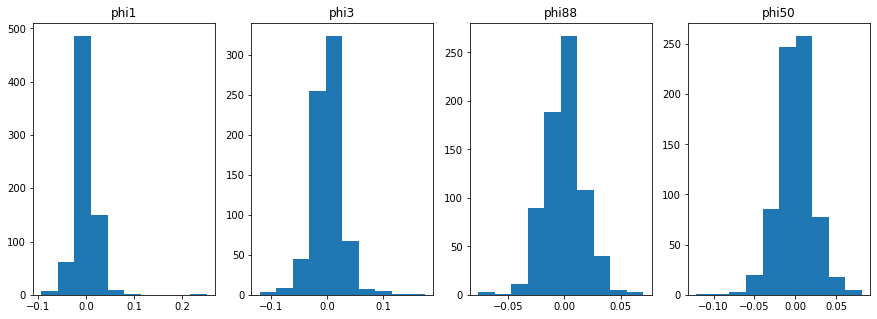

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5)) #plot some variables, looking for nan's and weirdness
axs[0].hist(df_raw.phi1)
axs[0].set_title('phi1')
axs[1].hist(df_raw.phi3)
axs[1].set_title('phi3')
axs[2].hist(df_raw.phi88)
axs[2].set_title('phi88')
axs[3].hist(df_raw.phi50)
axs[3].set_title('phi50')

In [ ]:
df_proc=df_raw.drop(columns=['patient_id'])
df_proc=df_proc.drop(columns=['ecg_id'])

In [ ]:
cont_names=[]; #defining the continuous variables
for col in df_proc.columns: 
    cont_names.append(col) #select all columns of the csv


In [ ]:
#cont_names.remove('ecg_id') #remove ecvg_id (categorical variable)
#cont_names.remove('patient_id') #remove patient_id (categorical variable)
cont_names.remove('norm') #remove norm (categorical variable)

## Add labels

In [ ]:
labels = pd.read_csv('/content/EKG_records_diag_4k_filtered_up.csv') #read the csv file
labels=labels.drop(columns=['EKGID'])
labels #show the csv file


,targ1,targ2,targ3,targ4,...,targ73,targ74,targ75,targ76
0,1,0,0,0,...,0,0,0,0
1,0,0,0,0,...,0,0,0,0
2,0,0,0,0,...,0,0,0,0
3,0,0,0,0,...,0,0,0,0
4,0,0,0,0,...,0,0,0,0
...,...,...,...,...,...,...,...,...,...
712,0,0,0,0,...,0,0,0,0
713,0,0,0,0,...,0,0,0,0
714,0,0,0,0,...,0,0,0,0
715,0,0,0,0,...,0,0,0,0


In [ ]:
df_label=pd.concat([df_proc,labels],axis=1)
df_label

,norm,phi1,phi2,phi3,...,targ73,targ74,targ75,targ76
0,1,-0.013816,-0.046324,-0.032499,...,0,0,0,0
1,1,-0.007283,0.047250,0.054529,...,0,0,0,0
2,1,0.007378,0.005525,-0.001845,...,0,0,0,0
3,1,0.010824,0.067227,0.056394,...,0,0,0,0
4,1,-0.009129,-0.009523,-0.000397,...,0,0,0,0
...,...,...,...,...,...,...,...,...,...
712,1,-0.050721,-0.054437,-0.003694,...,0,0,0,0
713,0,0.053600,0.035389,-0.018227,...,0,0,0,0
714,0,0.020266,0.043245,0.022965,...,0,0,0,0
715,0,0.000655,0.009969,0.009334,...,0,0,0,0


In [ ]:
# rslt_df = df_label.loc[df_label['x__1'] == 5]
# rslt_df=rslt_df.sample(n = 200)


In [ ]:
# df_label_drop=df_label.drop(rslt_df.index,)
# df_label_drop=df_label_drop.reset_index(drop=True)
# df_label_drop['x__1'] += 1
# df_label_drop

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(5, 5)) #plot some variables, looking for nan's and weirdness
# axs[0].hist(df_label.col1)
# axs[0].set_title('label')
# axs[1].hist(df_label.col1)
# axs[1].set_title('label')

In [ ]:
procs = [Categorify, FillMissing, Normalize]
cat_names = ['norm']

In [ ]:
splits = RandomSplitter()(range_of(df_label))
y_names = []

for x in range(1, 77):
    y_names.append('targ'+str(x))

In [ ]:
splits

((#574) [311,440,366,714,502,149,535,139,428,284...],
 (#143) [437,48,239,285,195,520,651,194,328,463...])

In [ ]:
to = TabularPandas(df_label, procs, cat_names, cont_names, y_names=y_names, y_block=MultiCategoryBlock(encoded=True, vocab=y_names), 
                   splits=splits
                   )

In [ ]:
dls = TabularDataLoaders.from_df(df_label, y_names=y_names, #select norm column as target
    cat_names = ['norm'], 
    y_block=MultiCategoryBlock(encoded=True, vocab=y_names), #select categorical variables and set output as cat
    cont_names = cont_names, #set contiuous variables from list above
    procs = [Categorify, FillMissing, Normalize]) #preprocessing

In [ ]:
dls.show(3) #verify df is working

,norm,phi1,phi2,phi3,phi4,phi5,phi6,phi7,phi8,phi9,phi10,phi11,phi12,phi13,phi14,phi15,phi16,phi17,phi18,phi19,phi20,phi21,phi22,phi23,phi24,phi25,phi26,phi27,phi28,phi29,phi30,phi31,phi32,phi33,phi34,phi35,phi36,phi37,phi38,phi39,phi40,phi41,phi42,phi43,phi44,phi45,phi46,phi47,phi48,phi49,phi50,phi51,phi52,phi53,phi54,phi55,phi56,phi57,phi58,phi59,phi60,phi61,phi62,phi63,phi64,phi65,phi66,phi67,phi68,phi69,phi70,phi71,phi72,phi73,phi74,phi75,phi76,phi77,phi78,phi79,phi80,phi81,phi82,phi83,phi84,phi85,phi86,phi87,phi88,phi89,phi90,phi91,phi92,phi93,phi94,phi95,phi96,phi97,phi98,phi99,phi100,phi101,phi102,phi103,phi104,phi105,phi106,phi107,phi108,phi109,phi110,phi111,phi112,phi113,phi114,phi115,phi116,phi117,phi118,phi119,phi120,phi121,phi122,phi123,phi124,phi125,phi126,phi127,phi128,phi129,phi130,phi131,phi132,phi133,phi134,phi135,phi136,phi137,phi138,phi139,phi140,phi141,phi142,phi143,phi144,phi145,phi146,phi147,phi148,phi149,phi150,phi151,phi152,phi153,phi154,phi155,phi156,phi157,phi158,phi159,phi160,phi161,phi162,phi163,phi164,phi165,phi166,phi167,phi168,phi169,phi170,phi171,phi172,phi173,phi174,phi175,phi176,phi177,phi178,phi179,phi180,phi181,phi182,phi183,phi184,phi185,phi186,phi187,phi188,phi189,phi190,phi191,phi192,phi193,phi194,phi195,phi196,phi197,phi198,phi199,phi200,phi201,phi202,phi203,phi204,phi205,phi206,phi207,phi208,phi209,phi210,phi211,phi212,phi213,phi214,phi215,phi216,phi217,phi218,phi219,phi220,phi221,phi222,phi223,phi224,phi225,phi226,phi227,phi228,phi229,phi230,phi231,phi232,phi233,phi234,phi235,phi236,phi237,phi238,phi239,phi240,phi241,phi242,phi243,phi244,phi245,phi246,phi247,phi248,phi249,phi250,phi251,phi252,phi253,phi254,phi255,phi256,phi257,phi258,phi259,phi260,phi261,phi262,phi263,phi264,phi265,phi266,phi267,phi268,phi269,phi270,phi271,phi272,phi273,phi274,phi275,phi276,phi277,phi278,phi279,phi280,phi281,phi282,phi283,phi284,phi285,phi286,phi287,phi288,phi289,phi290,phi291,phi292,phi293,phi294,phi295,phi296,phi297,phi298,phi299,phi300,phi301,phi302,phi303,phi304,phi305,phi306,phi307,phi308,phi309,phi310,phi311,phi312,phi313,phi314,phi315,phi316,phi317,phi318,phi319,phi320,phi321,phi322,phi323,phi324,phi325,phi326,phi327,phi328,phi329,phi330,phi331,phi332,phi333,phi334,phi335,phi336,phi337,phi338,phi339,phi340,phi341,phi342,phi343,phi344,phi345,phi346,phi347,phi348,phi349,phi350,phi351,phi352,phi353,phi354,phi355,phi356,phi357,phi358,phi359,phi360,phi361,phi362,phi363,phi364,phi365,phi366,phi367,phi368,phi369,phi370,phi371,phi372,phi373,phi374,phi375,phi376,phi377,phi378,phi379,phi380,phi381,phi382,phi383,phi384,phi385,phi386,phi387,phi388,phi389,phi390,phi391,phi392,phi393,phi394,phi395,phi396,phi397,phi398,phi399,phi400,phi401,phi402,phi403,phi404,phi405,phi406,phi407,phi408,phi409,phi410,phi411,phi412,phi413,phi414,phi415,phi416,phi417,phi418,phi419,phi420,phi421,phi422,phi423,phi424,phi425,phi426,phi427,phi428,phi429,phi430,phi431,phi432,phi433,phi434,phi435,phi436,phi437,phi438,phi439,phi440,phi441,phi442,phi443,phi444,phi445,phi446,phi447,phi448,phi449,phi450,phi451,phi452,phi453,phi454,phi455,phi456,phi457,phi458,phi459,phi460,phi461,phi462,phi463,phi464,phi465,phi466,phi467,phi468,phi469,phi470,phi471,phi472,phi473,phi474,phi475,phi476,phi477,phi478,phi479,phi480,phi481,phi482,phi483,phi484,phi485,phi486,phi487,phi488,phi489,phi490,phi491,phi492,phi493,phi494,phi495,phi496,phi497,phi498,phi499,phi500,phi501,phi502,phi503,phi504,phi505,phi506,phi507,phi508,phi509,phi510,phi511,phi512,phi513,phi514,phi515,phi516,phi517,phi518,phi519,phi520,phi521,phi522,phi523,phi524,phi525,phi526,phi527,phi528,phi529,phi530,phi531,phi532,phi533,phi534,phi535,phi536,phi537,phi538,phi539,phi540,phi541,phi542,phi543,phi544,phi545,phi546,phi547,phi548,phi549,phi550,phi551,phi552,phi553,phi554,phi555,phi556,phi557,phi558,phi559,phi560,phi561,phi562,phi563,phi564,phi565,phi566,phi567,phi568,phi569,phi570,phi571,phi572,targ1,targ2,targ3,targ4,targ5,targ6,targ7,targ8,targ9,targ10,targ11,targ12,targ13,targ14,targ15,ta

In [ ]:
dls = to.dataloaders()
dls.valid.show_batch()

,norm,phi1,phi2,phi3,phi4,phi5,phi6,phi7,phi8,phi9,phi10,phi11,phi12,phi13,phi14,phi15,phi16,phi17,phi18,phi19,phi20,phi21,phi22,phi23,phi24,phi25,phi26,phi27,phi28,phi29,phi30,phi31,phi32,phi33,phi34,phi35,phi36,phi37,phi38,phi39,phi40,phi41,phi42,phi43,phi44,phi45,phi46,phi47,phi48,phi49,phi50,phi51,phi52,phi53,phi54,phi55,phi56,phi57,phi58,phi59,phi60,phi61,phi62,phi63,phi64,phi65,phi66,phi67,phi68,phi69,phi70,phi71,phi72,phi73,phi74,phi75,phi76,phi77,phi78,phi79,phi80,phi81,phi82,phi83,phi84,phi85,phi86,phi87,phi88,phi89,phi90,phi91,phi92,phi93,phi94,phi95,phi96,phi97,phi98,phi99,phi100,phi101,phi102,phi103,phi104,phi105,phi106,phi107,phi108,phi109,phi110,phi111,phi112,phi113,phi114,phi115,phi116,phi117,phi118,phi119,phi120,phi121,phi122,phi123,phi124,phi125,phi126,phi127,phi128,phi129,phi130,phi131,phi132,phi133,phi134,phi135,phi136,phi137,phi138,phi139,phi140,phi141,phi142,phi143,phi144,phi145,phi146,phi147,phi148,phi149,phi150,phi151,phi152,phi153,phi154,phi155,phi156,phi157,phi158,phi159,phi160,phi161,phi162,phi163,phi164,phi165,phi166,phi167,phi168,phi169,phi170,phi171,phi172,phi173,phi174,phi175,phi176,phi177,phi178,phi179,phi180,phi181,phi182,phi183,phi184,phi185,phi186,phi187,phi188,phi189,phi190,phi191,phi192,phi193,phi194,phi195,phi196,phi197,phi198,phi199,phi200,phi201,phi202,phi203,phi204,phi205,phi206,phi207,phi208,phi209,phi210,phi211,phi212,phi213,phi214,phi215,phi216,phi217,phi218,phi219,phi220,phi221,phi222,phi223,phi224,phi225,phi226,phi227,phi228,phi229,phi230,phi231,phi232,phi233,phi234,phi235,phi236,phi237,phi238,phi239,phi240,phi241,phi242,phi243,phi244,phi245,phi246,phi247,phi248,phi249,phi250,phi251,phi252,phi253,phi254,phi255,phi256,phi257,phi258,phi259,phi260,phi261,phi262,phi263,phi264,phi265,phi266,phi267,phi268,phi269,phi270,phi271,phi272,phi273,phi274,phi275,phi276,phi277,phi278,phi279,phi280,phi281,phi282,phi283,phi284,phi285,phi286,phi287,phi288,phi289,phi290,phi291,phi292,phi293,phi294,phi295,phi296,phi297,phi298,phi299,phi300,phi301,phi302,phi303,phi304,phi305,phi306,phi307,phi308,phi309,phi310,phi311,phi312,phi313,phi314,phi315,phi316,phi317,phi318,phi319,phi320,phi321,phi322,phi323,phi324,phi325,phi326,phi327,phi328,phi329,phi330,phi331,phi332,phi333,phi334,phi335,phi336,phi337,phi338,phi339,phi340,phi341,phi342,phi343,phi344,phi345,phi346,phi347,phi348,phi349,phi350,phi351,phi352,phi353,phi354,phi355,phi356,phi357,phi358,phi359,phi360,phi361,phi362,phi363,phi364,phi365,phi366,phi367,phi368,phi369,phi370,phi371,phi372,phi373,phi374,phi375,phi376,phi377,phi378,phi379,phi380,phi381,phi382,phi383,phi384,phi385,phi386,phi387,phi388,phi389,phi390,phi391,phi392,phi393,phi394,phi395,phi396,phi397,phi398,phi399,phi400,phi401,phi402,phi403,phi404,phi405,phi406,phi407,phi408,phi409,phi410,phi411,phi412,phi413,phi414,phi415,phi416,phi417,phi418,phi419,phi420,phi421,phi422,phi423,phi424,phi425,phi426,phi427,phi428,phi429,phi430,phi431,phi432,phi433,phi434,phi435,phi436,phi437,phi438,phi439,phi440,phi441,phi442,phi443,phi444,phi445,phi446,phi447,phi448,phi449,phi450,phi451,phi452,phi453,phi454,phi455,phi456,phi457,phi458,phi459,phi460,phi461,phi462,phi463,phi464,phi465,phi466,phi467,phi468,phi469,phi470,phi471,phi472,phi473,phi474,phi475,phi476,phi477,phi478,phi479,phi480,phi481,phi482,phi483,phi484,phi485,phi486,phi487,phi488,phi489,phi490,phi491,phi492,phi493,phi494,phi495,phi496,phi497,phi498,phi499,phi500,phi501,phi502,phi503,phi504,phi505,phi506,phi507,phi508,phi509,phi510,phi511,phi512,phi513,phi514,phi515,phi516,phi517,phi518,phi519,phi520,phi521,phi522,phi523,phi524,phi525,phi526,phi527,phi528,phi529,phi530,phi531,phi532,phi533,phi534,phi535,phi536,phi537,phi538,phi539,phi540,phi541,phi542,phi543,phi544,phi545,phi546,phi547,phi548,phi549,phi550,phi551,phi552,phi553,phi554,phi555,phi556,phi557,phi558,phi559,phi560,phi561,phi562,phi563,phi564,phi565,phi566,phi567,phi568,phi569,phi570,phi571,phi572,targ1,targ2,targ3,targ4,targ5,targ6,targ7,targ8,targ9,targ10,targ11,targ12,targ13,targ14,targ15,ta

In [ ]:
learn = tabular_learner(dls, metrics=[accuracy_multi], 
                        wd=0.15,
                        layers=[1000,100]
                        )
                         #formulate tabular learner

In [ ]:
learn.fit_one_cycle(40) #train for ten epochs

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.735362,0.700329,0.481597,00:00
1,0.731803,0.702945,0.502484,00:00
2,0.726913,0.709598,0.511594,00:00
3,0.720771,0.716059,0.509753,00:00
4,0.714286,0.714353,0.516194,00:00
5,0.707424,0.709509,0.522267,00:00
6,0.700307,0.700154,0.543982,00:00
7,0.692710,0.688745,0.568366,00:00
8,0.684041,0.675605,0.601031,00:00
9,0.673418,0.648795,0.656606,00:00


In [ ]:
learn.show_results()

,norm,phi1,phi2,phi3,phi4,phi5,phi6,phi7,phi8,phi9,phi10,phi11,phi12,phi13,phi14,phi15,phi16,phi17,phi18,phi19,phi20,phi21,phi22,phi23,phi24,phi25,phi26,phi27,phi28,phi29,phi30,phi31,phi32,phi33,phi34,phi35,phi36,phi37,phi38,phi39,phi40,phi41,phi42,phi43,phi44,phi45,phi46,phi47,phi48,phi49,phi50,phi51,phi52,phi53,phi54,phi55,phi56,phi57,phi58,phi59,phi60,phi61,phi62,phi63,phi64,phi65,phi66,phi67,phi68,phi69,phi70,phi71,phi72,phi73,phi74,phi75,phi76,phi77,phi78,phi79,phi80,phi81,phi82,phi83,phi84,phi85,phi86,phi87,phi88,phi89,phi90,phi91,phi92,phi93,phi94,phi95,phi96,phi97,phi98,phi99,phi100,phi101,phi102,phi103,phi104,phi105,phi106,phi107,phi108,phi109,phi110,phi111,phi112,phi113,phi114,phi115,phi116,phi117,phi118,phi119,phi120,phi121,phi122,phi123,phi124,phi125,phi126,phi127,phi128,phi129,phi130,phi131,phi132,phi133,phi134,phi135,phi136,phi137,phi138,phi139,phi140,phi141,phi142,phi143,phi144,phi145,phi146,phi147,phi148,phi149,phi150,phi151,phi152,phi153,phi154,phi155,phi156,phi157,phi158,phi159,phi160,phi161,phi162,phi163,phi164,phi165,phi166,phi167,phi168,phi169,phi170,phi171,phi172,phi173,phi174,phi175,phi176,phi177,phi178,phi179,phi180,phi181,phi182,phi183,phi184,phi185,phi186,phi187,phi188,phi189,phi190,phi191,phi192,phi193,phi194,phi195,phi196,phi197,phi198,phi199,phi200,phi201,phi202,phi203,phi204,phi205,phi206,phi207,phi208,phi209,phi210,phi211,phi212,phi213,phi214,phi215,phi216,phi217,phi218,phi219,phi220,phi221,phi222,phi223,phi224,phi225,phi226,phi227,phi228,phi229,phi230,phi231,phi232,phi233,phi234,phi235,phi236,phi237,phi238,phi239,phi240,phi241,phi242,phi243,phi244,phi245,phi246,phi247,phi248,phi249,phi250,phi251,phi252,phi253,phi254,phi255,phi256,phi257,phi258,phi259,phi260,phi261,phi262,phi263,phi264,phi265,phi266,phi267,phi268,phi269,phi270,phi271,phi272,phi273,phi274,phi275,phi276,phi277,phi278,phi279,phi280,phi281,phi282,phi283,phi284,phi285,phi286,phi287,phi288,phi289,phi290,phi291,phi292,phi293,phi294,phi295,phi296,phi297,phi298,phi299,phi300,phi301,phi302,phi303,phi304,phi305,phi306,phi307,phi308,phi309,phi310,phi311,phi312,phi313,phi314,phi315,phi316,phi317,phi318,phi319,phi320,phi321,phi322,phi323,phi324,phi325,phi326,phi327,phi328,phi329,phi330,phi331,phi332,phi333,phi334,phi335,phi336,phi337,phi338,phi339,phi340,phi341,phi342,phi343,phi344,phi345,phi346,phi347,phi348,phi349,phi350,phi351,phi352,phi353,phi354,phi355,phi356,phi357,phi358,phi359,phi360,phi361,phi362,phi363,phi364,phi365,phi366,phi367,phi368,phi369,phi370,phi371,phi372,phi373,phi374,phi375,phi376,phi377,phi378,phi379,phi380,phi381,phi382,phi383,phi384,phi385,phi386,phi387,phi388,phi389,phi390,phi391,phi392,phi393,phi394,phi395,phi396,phi397,phi398,phi399,phi400,phi401,phi402,phi403,phi404,phi405,phi406,phi407,phi408,phi409,phi410,phi411,phi412,phi413,phi414,phi415,phi416,phi417,phi418,phi419,phi420,phi421,phi422,phi423,phi424,phi425,phi426,phi427,phi428,phi429,phi430,phi431,phi432,phi433,phi434,phi435,phi436,phi437,phi438,phi439,phi440,phi441,phi442,phi443,phi444,phi445,phi446,phi447,phi448,phi449,phi450,phi451,phi452,phi453,phi454,phi455,phi456,phi457,phi458,phi459,phi460,phi461,phi462,phi463,phi464,phi465,phi466,phi467,phi468,phi469,phi470,phi471,phi472,phi473,phi474,phi475,phi476,phi477,phi478,phi479,phi480,phi481,phi482,phi483,phi484,phi485,phi486,phi487,phi488,phi489,phi490,phi491,phi492,phi493,phi494,phi495,phi496,phi497,phi498,phi499,phi500,phi501,phi502,phi503,phi504,phi505,phi506,phi507,phi508,phi509,phi510,phi511,phi512,phi513,phi514,phi515,phi516,phi517,phi518,phi519,phi520,phi521,phi522,phi523,phi524,phi525,phi526,phi527,phi528,phi529,phi530,phi531,phi532,phi533,phi534,phi535,phi536,phi537,phi538,phi539,phi540,phi541,phi542,phi543,phi544,phi545,phi546,phi547,phi548,phi549,phi550,phi551,phi552,phi553,phi554,phi555,phi556,phi557,phi558,phi559,phi560,phi561,phi562,phi563,phi564,phi565,phi566,phi567,phi568,phi569,phi570,phi571,phi572,targ1,targ2,targ3,targ4,targ5,targ6,targ7,targ8,targ9,targ10,targ11,targ12,targ13,targ14,targ15,ta

In [ ]:
output1=pd.DataFrame(preds)
output2=pd.DataFrame(y)
output3=pd.DataFrame(losses)
output1.to_csv('/content/preds.csv')
output2.to_csv('/content/y.csv')
output3.to_csv('/content/losses.csv')


In [ ]:
preds

tensor([[0.4688, 0.5157, 0.4232,  ..., 0.4575, 0.6947, 0.5407],
        [0.3668, 0.5160, 0.5951,  ..., 0.5025, 0.6075, 0.5749],
        [0.5118, 0.5374, 0.4348,  ..., 0.5072, 0.6046, 0.4577],
        ...,
        [0.5389, 0.4882, 0.5014,  ..., 0.5721, 0.4781, 0.6090],
        [0.6801, 0.4651, 0.5678,  ..., 0.6279, 0.4807, 0.5228],
        [0.5698, 0.5618, 0.4779,  ..., 0.4838, 0.4051, 0.5635]])

In [ ]:
y

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], dtype=torch.int8)

In [ ]:
losses

TensorBase([1.2114, 0.8166, 0.8067, 0.7750, 0.7721, 0.7673, 0.7669, 0.7602, 0.7496, 0.7481, 0.7464, 0.7439, 0.7435, 0.7430, 0.7397, 0.7383, 0.7380, 0.7378, 0.7375, 0.7357, 0.7338, 0.7329, 0.7317, 0.7234,
        0.7225, 0.7216, 0.7201, 0.7193, 0.7192, 0.7188, 0.7161, 0.7160, 0.7157, 0.7141, 0.7135, 0.7132, 0.7118, 0.7113, 0.7112, 0.7099, 0.7089, 0.7068, 0.7044, 0.7038, 0.7036, 0.7018, 0.7014, 0.7012,
        0.7007, 0.7006, 0.6997, 0.6990, 0.6989, 0.6986, 0.6985, 0.6975, 0.6964, 0.6961, 0.6949, 0.6947, 0.6947, 0.6947, 0.6945, 0.6944, 0.6943, 0.6942, 0.6942, 0.6938, 0.6936, 0.6933, 0.6927, 0.6923,
        0.6911, 0.6909, 0.6897, 0.6896, 0.6896, 0.6891, 0.6891, 0.6890, 0.6887, 0.6885, 0.6882, 0.6880, 0.6880, 0.6867, 0.6865, 0.6865, 0.6861, 0.6860, 0.6858, 0.6845, 0.6845, 0.6833, 0.6830, 0.6826,
        0.6809, 0.6796, 0.6796, 0.6795, 0.6795, 0.6792, 0.6789, 0.6788, 0.6771, 0.6768, 0.6766, 0.6759, 0.6756, 0.6751, 0.6750, 0.6746, 0.6744, 0.6737, 0.6736, 0.6732, 0.6731, 0.6730, 0.6714, 0.67

In [ ]:
preds,y,losses=learn.get_preds(with_loss=True)
interp = ClassificationInterpretation.from_learner(learn)

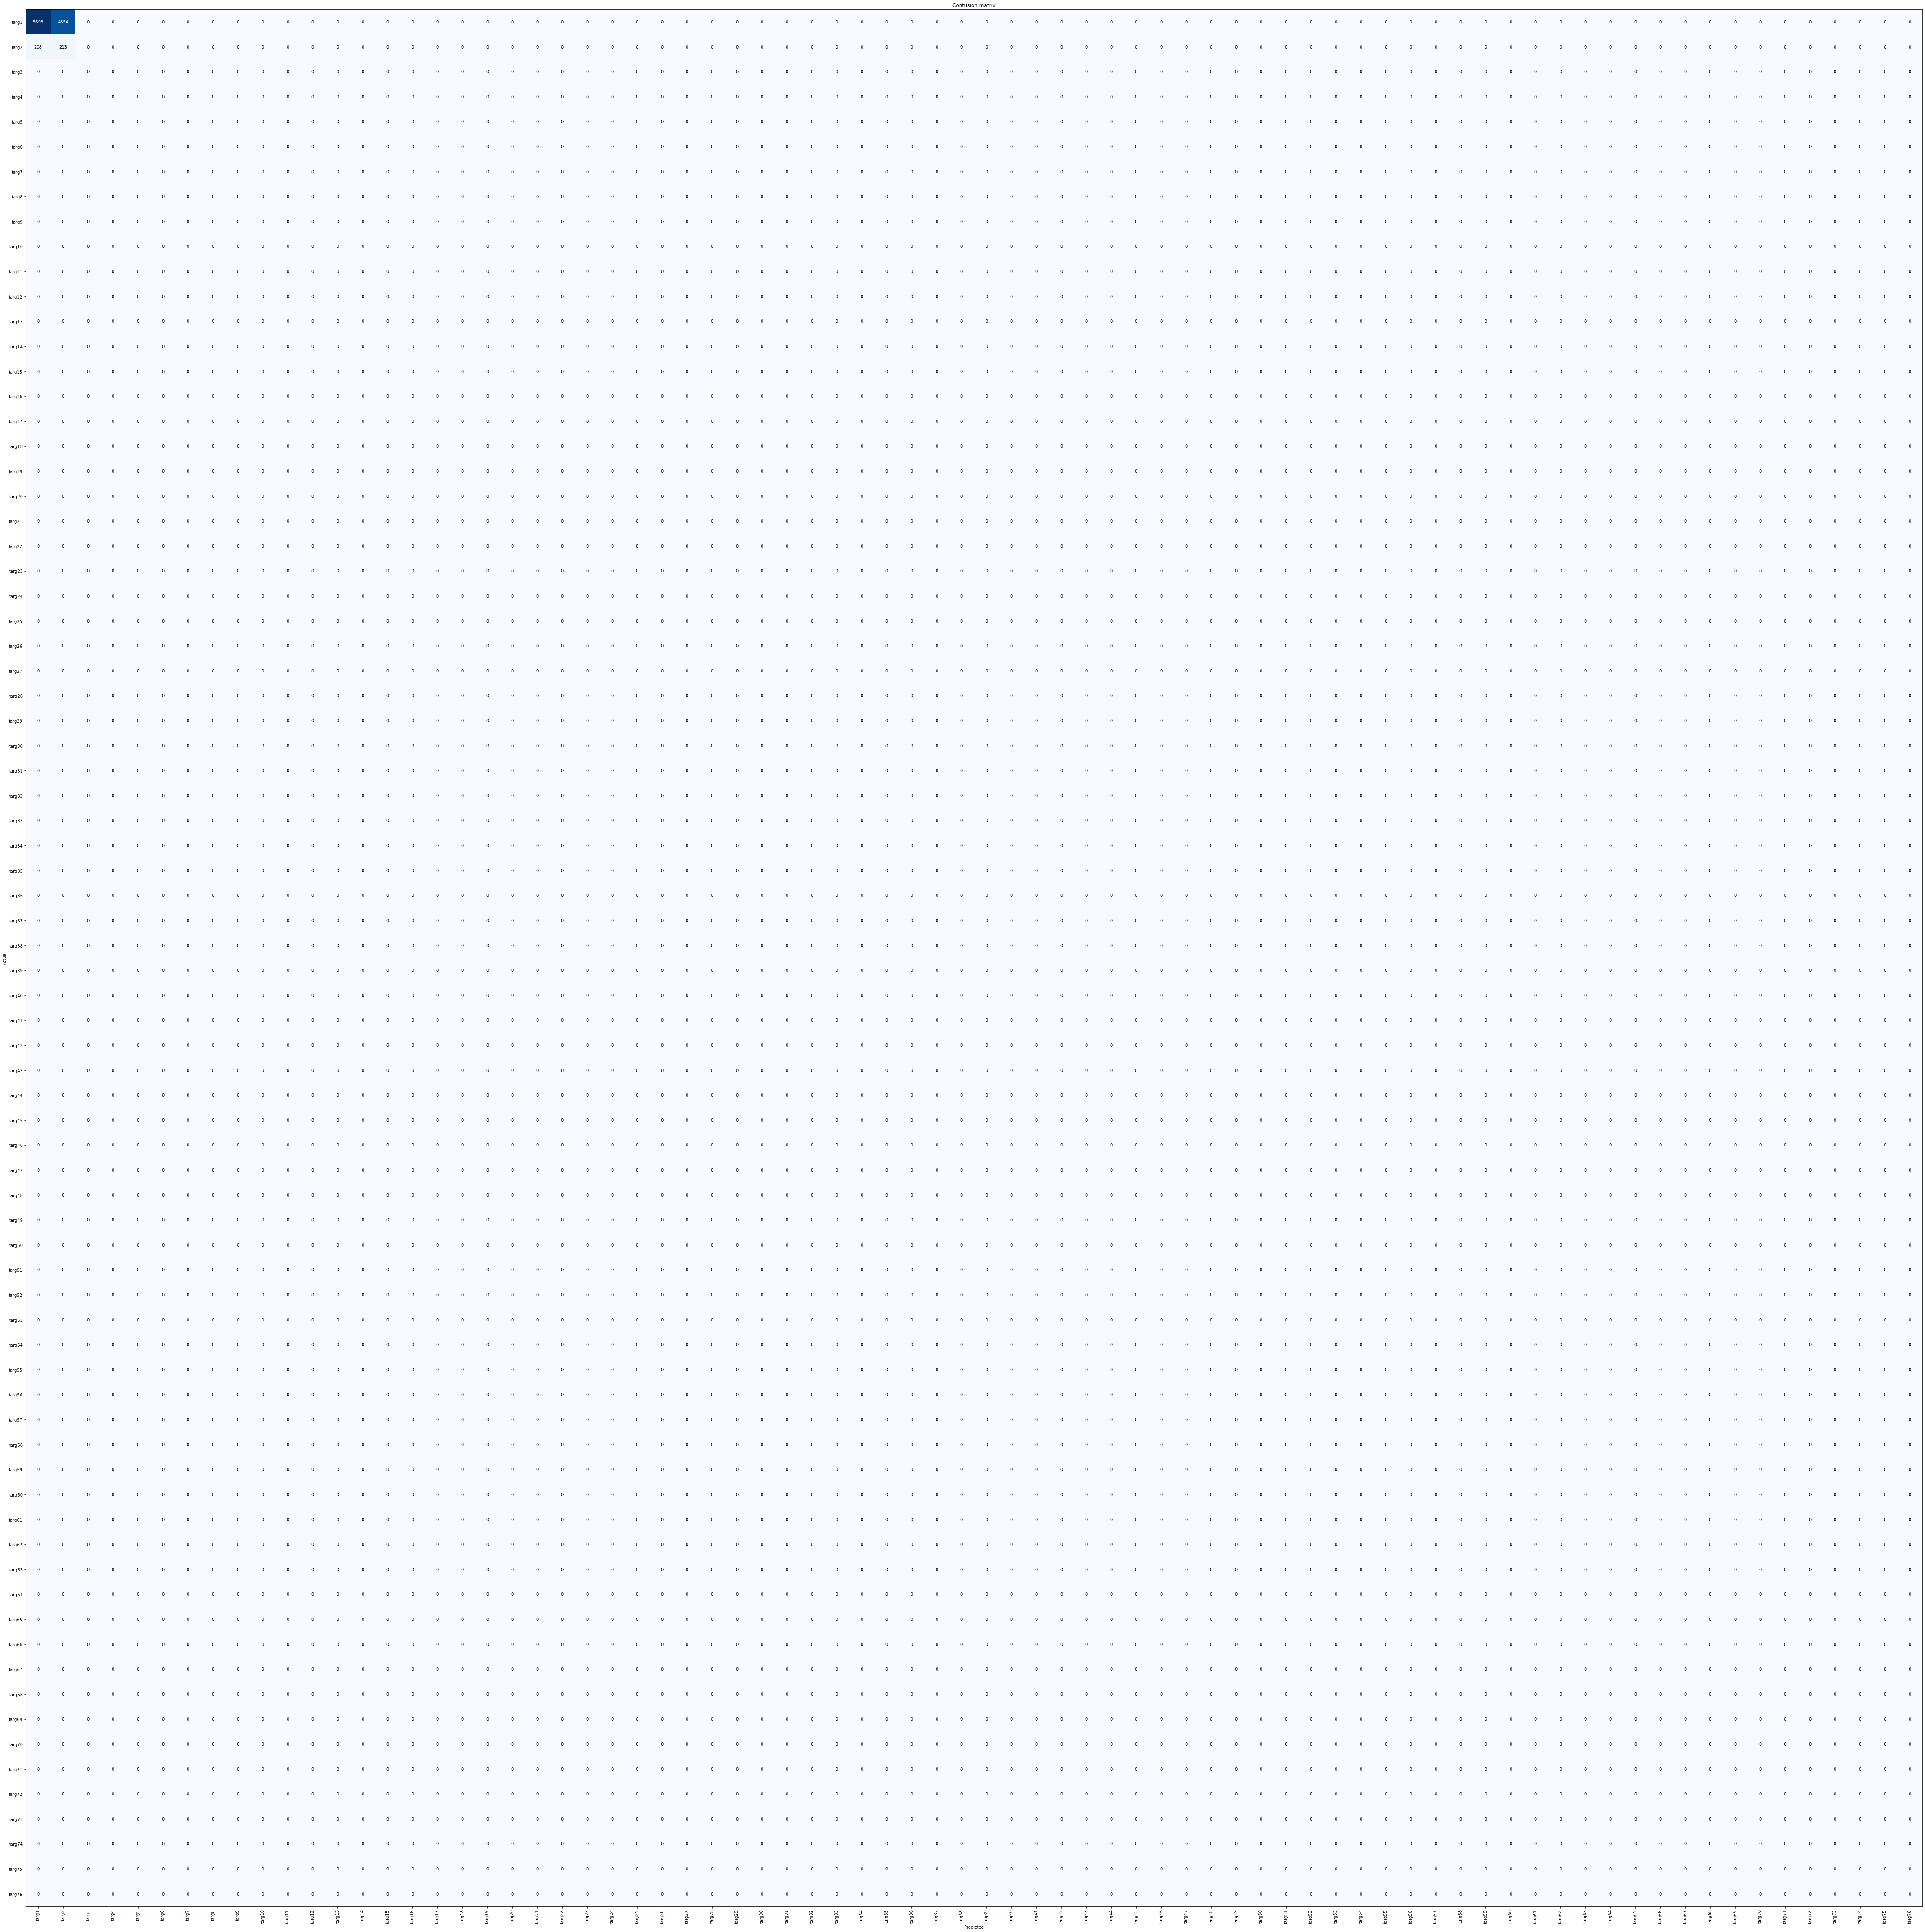

In [ ]:
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(64,64))

# Fancy Heatmap for Later

In [ ]:
# import numpy as np; np.random.seed(0)

# import seaborn as sns; sns.set_theme()
# import matplotlib.pyplot as plt

# uniform_data = np.random.rand(10, 12)

In [ ]:
# np.shape(uniform_data)
# data_seize=np.array([[191, 8], [12, 453]])
# x_axis_labels = ['Seizure','non-Seizure']
# y_axis_labels = ['Seizure','non-Seizure']

In [ ]:


# ax = sns.heatmap(data_seize,annot=True,xticklabels=x_axis_labels,yticklabels=y_axis_labels)

In [ ]:
# fig, ax = plt.subplots(figsize=(8,6))
# sns.heatmap(data_seize,annot=True,xticklabels=x_axis_labels,yticklabels=y_axis_labels)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()